## Results below were produced using a 100Gbps NIC, for 10Gbps results please refer to our paper

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import re

def parse_microbenchmark_log(wnum, rank, lib, mode, density):
    time_array = []
    with open(f"10G-results/{str(wnum)}-{str(rank)}/{lib}-{mode}/{str(density)}.log", "r", encoding='UTF-8') as f:
        lines = [line for line in f]
    for line in lines:
        line = line.strip()
        x = re.search("time:(.*);", line)
        if x is not None:
            batch_time = float(x.group(1))
            time_array.append(batch_time)
    return np.array(time_array)/1000

# Figure 4

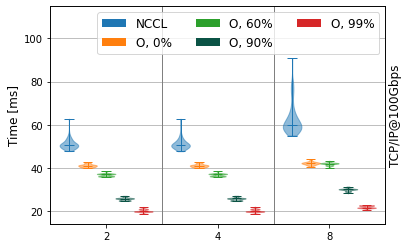

In [14]:
colors =  ['#1f77b4', '#ff7f0e','#2ca02c', '#0b5345','#d62728','#9467bd',  '#8c564b']
wnums = [2, 4, 8]
legend = ['NCCL', \
          'O, 0%', \
          'O, 60%', \
          'O, 90%', \
          'O, 99%'
          ]
#densities = [1.0, 0.8, 0.4, 0.2, 0.1, 0.08, 0.04, 0.02, 0.01]
densities = [1.0, 0.4, 0.1, 0.01]
patches = [mpatches.Patch(label=label) for label in legend]
fig, (ax) = plt.subplots(1,1)
fig.set_size_inches(6,4)
# plot RDMA
data_all = []
data = []
for w in wnums:
    for r in range(w):
        data.append(parse_microbenchmark_log(w, r, 'NCCL', 'TCPIP', 1.0))
data_all.append(data)
for d in densities:
    data = []
    for w in wnums:
        for r in range(w):
            data.append(parse_microbenchmark_log(w, r, 'omnireduce', 'DPDK', d))
    data_all.append(data)
    
num_columns = len(wnums)
ax.yaxis.grid(True, which='major', zorder=1)
for p in np.arange(num_columns-1):
    ax.axvline(x=p+0.5, color='gray', linewidth=1)
plt.xlim(-0.5, num_columns-0.5)

num_plots = len(data_all)

for i in range(num_plots):
    pos = np.arange(len(data_all[i])) -0.5 + ((i+1)/(num_plots+1))
    violin_parts = ax.violinplot(data_all[i], showmeans=False, showmedians=True, widths=1/(num_plots+1),
                                     positions=pos, showextrema=True)
    for partname in ('cbars','cmins','cmaxes','cmedians'):
        vp = violin_parts[partname]
        vp.set_linewidth(1)
        vp.set_facecolor(colors[i])
        vp.set_edgecolor(colors[i])
    for pc in violin_parts['bodies']:
        pc.set_alpha(0.5)
        pc.set_zorder(2)
        pc.set_facecolor(colors[i])
        pc.set_edgecolor(colors[i])
    patches[i].set_fc(violin_parts['bodies'][0].get_facecolor()[0][0:3])
    
num_columns = len(wnums)
plt.xlim(-0.5, num_columns-0.5)

num_plots = len(data_all)

ax.set_ylabel('Time [ms]', fontsize=12)
ax00 = ax.twinx()
ax00.tick_params(axis='y', right=False, labelright=False)
ax00.set_ylabel("TCP/IP@100Gbps", fontsize=12)
plt.setp(ax, xticks=[y for y in range(num_columns)],
     xticklabels=[str(pow(2,l+1)) for l in range(num_columns)])
plt.legend(handles=patches, ncol=3, fontsize=12)
# art = [plt.legend(handles=patches, loc=1, bbox_to_anchor=(0.95, 2.7), ncol=3, fontsize=12)]